In [1]:
import torch
import time
from utils.utils import generate_mask, load_model, writeDACFile
from dataloader.dataset import onehot, getNumClasses
from utils.utils import interpolate_vectors

import os
import yaml

from DACTransformer.DACTransformer import TransformerDecoder
from DACTransformer.CondQueryTransformer import ClassConditionedTransformer


import numpy as np
import matplotlib.pyplot as plt


In [2]:
### params
# Training data dir

# will morph between infsnd1[i] and infsnd2[i] (and back)
infsnd1 = ['pistons', 'wind', 'applause', 'bees'] # used for inference
#infsnd2 = ['pistons' , 'wind',   'applause', 'bees'] # used for inference
infsnd2 = ['wind',   'applause', 'bees', 'pistons' ] # used for inference

cond_size=8
experiment_name = '06.29' 
checkpoint_dir = 'runs' + '/' + experiment_name


# Load YAML file
with open(checkpoint_dir + '/' + 'params.yaml', 'r') as file:
    params = yaml.safe_load(file)
    
TransformerClass =  globals().get(params['TransformerClass'])  
print(f"using TransformerClass = {params['TransformerClass']}") 
print(f' and TransformerClass is class object {TransformerClass}')

cptnum =  100 #params['num_epochs'] # 300 #(must be in the checkpoint directory)

fnamebase='out' + '.e' + str(248) + '.l' + str(4) + '.h' + str(16) + '_chkpt_' + str(cptnum).zfill(4) 
checkpoint_path = checkpoint_dir + '/' +  fnamebase  + '.pth' 

# for saving sound 
outdir=checkpoint_dir

DEVICE='cpu' #####################################################''cuda'

inference_steps=86*20  #86 frames per second

minpval=0
maxpval=1

print(f'checkpoint_path = {checkpoint_path}, fnamebase = {fnamebase}' )

using TransformerClass = ClassConditionedTransformer
 and TransformerClass is class object <class 'DACTransformer.CondQueryTransformer.ClassConditionedTransformer'>
checkpoint_path = runs/06.29/out.e248.l4.h16_chkpt_0100.pth, fnamebase = out.e248.l4.h16_chkpt_0100


In [3]:
torch.cuda.device_count()
torch.cuda.get_device_properties(0).total_memory/1e9

device = torch.device(DEVICE) # if the docker was started with --gpus all, then can choose here with cuda:0 (or cpu)
torch.cuda.device_count()
print(f'memeory on cuda 0 is  {torch.cuda.get_device_properties(0).total_memory/1e9}')

device

memeory on cuda 0 is  25.216745472


device(type='cpu')

In [4]:
# This takes the output vector of activations ("logits") across the vocabulary, chooses the n maximally activated,
# does a softmax, and chooses according to their probablity

def select_top_n(logits, n):
    """
    Selects the next token from the top n logits using softmax probabilities.
    
    Parameters:
    logits (torch.Tensor): The logits tensor (1D tensor).
    n (int): The number of top logits to consider.

    Returns:
    int: The index of the selected token.
    """
    # Ensure n does not exceed the length of logits
    n = min(n, logits.size(0))

    # Step 1: Get the indices of the top n logits
    top_n_logits, top_n_indices = torch.topk(logits, n)
    
    # Step 2: Apply softmax to the top n logits
    top_n_probs = torch.softmax(top_n_logits, dim=0)
    
    # Step 3: Choose a token from the top n logits according to the probabilities
    selected_index_within_top_n = torch.multinomial(top_n_probs, 1).item()
    
    # Step 4: Map the selected index within top n back to the original index
    selected_token_index = top_n_indices[selected_index_within_top_n].item()
    
    return selected_token_index

# Example usage
logits = torch.tensor([1.0, 2.0, 3.0, 10.0, 0.5, 0.1, 0.2, 5.0])
n = 3
selected_token_index = select_top_n(logits, n)
print(f"Selected token index: {selected_token_index}")

Selected token index: 3


In [5]:
def inference(model, inference_cond, Ti, vocab_size, num_tokens, inference_steps, fname) :
    model.eval()
    mask = generate_mask(Ti, Ti).to(device)
    input_data = torch.randint(0, vocab_size, (1, Ti, num_tokens)).to(device)  # Smaller context window for inference
    predictions = []

    t0 = time.time()
    for i in range(inference_steps):  # Generate 100 tokens
        if cond_size == 0:
            output = model(input_data, None, mask) # step through 
        else : 
            output = model(input_data, inference_cond[:, i:Ti+i, :], mask) # step through

        # This takes the last vector of the sequence (the new predicted token stack) so has size(b,1,4,1024)
        # This it takes the max across the last dimension (scores for each element of the vocabulary (for each of the 4 tokens))
        # .max returns a duple of tensors, the first are the max vals (one for each token) and the second are the
        #        indices in the range of the vocabulary size. 
        # THAT IS, the 4 selected "best" tokens are taken independently
        next_token = output[:, -1, :, :].max(-1)[1]  # Greedy decoding for simplicity
        predictions.append(next_token)
        input_data = torch.cat([input_data, next_token.unsqueeze(1)], dim=1)[:, 1:]  # Slide window

    t1 = time.time()
    inf_time = t1-t0
    print(f'inference time for {inference_steps} steps, or {inference_steps/86} seconds of sound is {inf_time}' )

    dacseq = torch.cat(predictions, dim=0).unsqueeze(0).transpose(1, 2)
    if mask == None:
        writeDACFile(fname + '_unmasked', dacseq)
    else :
        writeDACFile(fname, dacseq)       

In [6]:
print(f' About to call load_model with TransformerClass = {TransformerClass}')
model, Ti, vocab_size, num_codebooks, cond_size = load_model(checkpoint_path,  TransformerClass)

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {num_params}')


model.to(device);








 About to call load_model with TransformerClass = <class 'DACTransformer.CondQueryTransformer.ClassConditionedTransformer'>
Total number of parameters: 5882592


/dacsynthformer/utils/utils.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_tensors = [torch.tensor(vec) for vec in v]


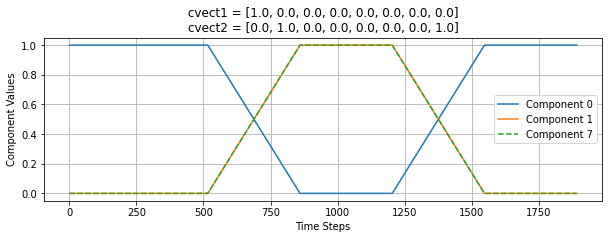

shape of inf_cond is  = torch.Size([1, 1893, 8])
outfname is runs/06.29/dacs/pistons.wind_steps_1720.minpval_0.00.maxpval_1.00
inference time for 1720 steps, or 20.0 seconds of sound is 20.859841346740723


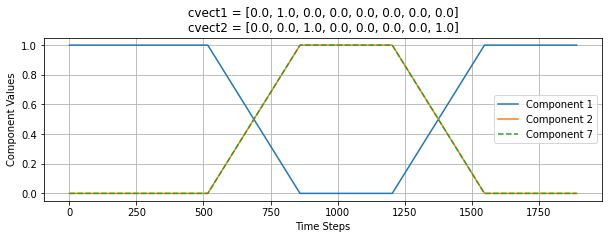

shape of inf_cond is  = torch.Size([1, 1893, 8])
outfname is runs/06.29/dacs/wind.applause_steps_1720.minpval_0.00.maxpval_1.00
inference time for 1720 steps, or 20.0 seconds of sound is 19.4102144241333


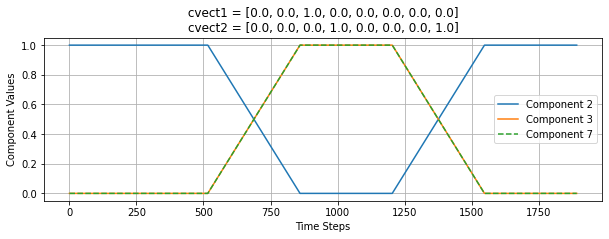

shape of inf_cond is  = torch.Size([1, 1893, 8])
outfname is runs/06.29/dacs/applause.bees_steps_1720.minpval_0.00.maxpval_1.00
inference time for 1720 steps, or 20.0 seconds of sound is 20.009488344192505


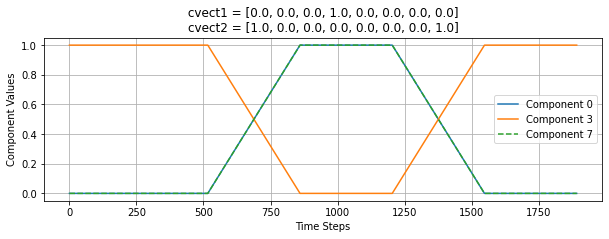

shape of inf_cond is  = torch.Size([1, 1893, 8])
outfname is runs/06.29/dacs/bees.pistons_steps_1720.minpval_0.00.maxpval_1.00
inference time for 1720 steps, or 20.0 seconds of sound is 19.872758388519287
Done


In [7]:

for snum in range(len(infsnd1)) : 
    if cond_size == 0 :
        inference_cond = None
    else : 
        one_hot_fvector1=onehot(infsnd1[snum]) #The parameter evolution over time will be the same for all sounds
        one_hot_fvector2=onehot(infsnd2[snum]) #The parameter evolution over time will be the same for all sounds

        cvect1=torch.cat((one_hot_fvector1, torch.tensor([minpval])))
        cvect2=torch.cat((one_hot_fvector2, torch.tensor([maxpval])))

        steps=[0,Ti+1*inference_steps//5, Ti+2*inference_steps//5, Ti+3*inference_steps//5, Ti+4*inference_steps//5, Ti+inference_steps]
        inference_cond=interpolate_vectors([cvect1,cvect1, cvect2, cvect2, cvect1, cvect1 ], steps) #length must cover staring context window+inf steps

        # Extract the 2D array of shape [n, m]
        data = inference_cond[0]

        # Find components that change over time
        changing_indices = [i for i in range(cond_size) if not torch.all(data[:, i] == data[0, i])]

        # Format the arrays as strings
        cvect1_str = ', '.join(map(str, cvect1.tolist()))
        cvect2_str = ', '.join(map(str, cvect2.tolist()))

        # Plot the changing components
        plt.figure(figsize=(10, 3))

        for i in changing_indices:
            if i != 7 :
                plt.plot(data[:, i], label=f'Component {i}')
            else : 
                plt.plot(data[:, i], label=f'Component {i}', linestyle='--')

        plt.xlabel('Time Steps')
        plt.ylabel('Component Values')
        plt.title(f' cvect1 = [{cvect1_str}] \ncvect2 = [{cvect2_str}]')
        plt.legend()
        plt.grid(True)
        plt.show()

        inference_cond=inference_cond.to(device)
        print(f'shape of inf_cond is  = {inference_cond.shape}') 

        
        outfname=outdir+"/"+ "dacs" + "/" +  infsnd1[snum] + "." + infsnd2[snum] +"_steps_"+str(inference_steps).zfill(4)+'.minpval_'+ f"{minpval:01.2f}" +'.maxpval_'+ f"{maxpval:01.2f}"
        print(f'outfname is {outfname}')
        inference(model, inference_cond, Ti, vocab_size, num_codebooks, inference_steps, outfname ) 

print('Done')